## Logistic Regression with Single Neuron Neural Network


### 1. Goals

1. Implement a single neuron neural network, aka, the logistic regression unit. 
2. Use Log Loss Function, write code to carry out stochastic gradient descent for optimization, and use sigmoid compression.
3. Run it on any classification problem using a dataset from the internet (say the titanic dataset).
4. Provide accuracy and F1 score of the results. 

#### 2. Imports

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

#### 3. Data Ingestion

Dataset used on this project is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.
https://www.kaggle.com/datasets/mathchi/diabetes-data-set 

In [107]:
#Import dataset
data= pd.read_csv('https://media.githubusercontent.com/media/midhunmohank/INFO7390/main/Assignment2/diabetes.csv')

In [108]:
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 4. Exploratory Data Analysis

1 : Glucose
2 : BMI
3 : DiabetesPedigreeFunction


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 1440x1080 with 0 Axes>

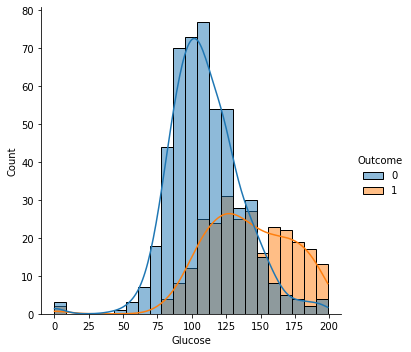

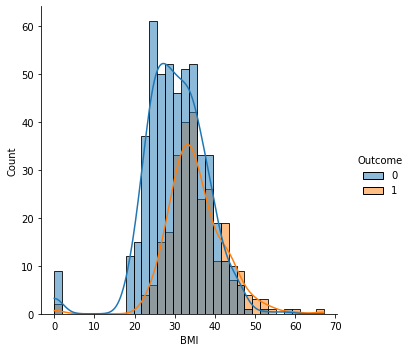

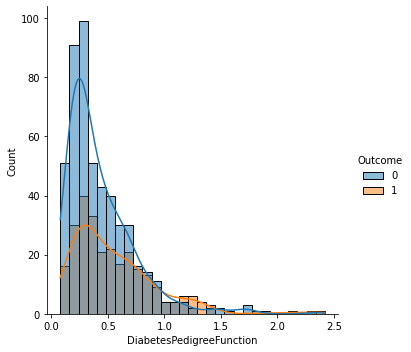

In [109]:
# displot 
features_listed = ['Glucose', 'BMI', 'DiabetesPedigreeFunction']
plt.figure(figsize = [20, 15])
counter = 0
for i in features_listed:
    counter += 1
    print(counter, ':', i)
    sns.displot(data = data, kde=True, x = data[str(i)], hue='Outcome')
plt.plot()
plt.show

In [110]:
# custom function for data vizualization
def look_at_distr_hist(*args, df_num=None, df_cat=None, class_feature="Outcome"):
    if df_num is not None:
        plt.figure(figsize = [20, 15])
        counter = 0
        for i in df_num.columns:
            counter += 1
            plt.subplot(3, 3, counter)
            sns.histplot(data = data, x = data[str(i)], hue = data[class_feature], multiple  = 'dodge')
        plt.plot()

    #look at the distribution for all categ variables
    if df_cat is not None:
        plt.figure(figsize = [20, 15])
        counter = 0
        for i in df_cat.columns:
            counter += 1
            plt.subplot(3, 3, counter)
            sns.histplot(data = data, x = data[str(i)], hue = data[class_feature], multiple  = 'dodge')
    plt.plot();

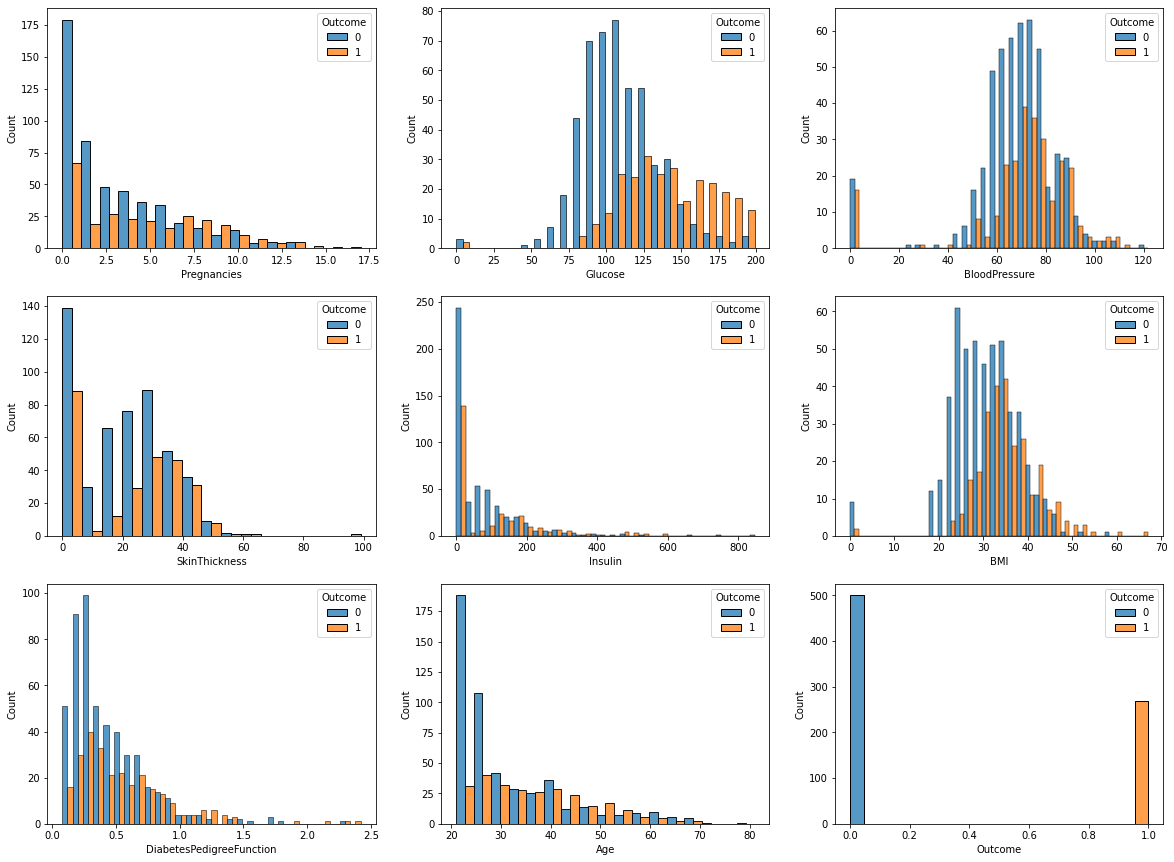

In [111]:
look_at_distr_hist(df_num=data, class_feature="Outcome")

#### 5. Data Preprocessing

In [112]:
#Train, test and validation spilt
from sklearn.model_selection import train_test_split

data_set_values=np.array(data)
number_of_rows,number_of_cols=data.shape
train, test = train_test_split(data_set_values, test_size = 0.4,random_state=57)
test, validate = train_test_split(test, test_size = 0.5,random_state=3)

In [113]:
#Spilt all sets into input and output sets
train_x=train[:,:number_of_cols-1]
train_y=train[:,[number_of_cols-1]]

test_x=test[:,:number_of_cols-1]
test_y=test[:,[number_of_cols-1]]

validate_x=validate[:,:number_of_cols-1]
validate_y=validate[:,[number_of_cols-1]]

#perform normalization on the input data set
input_data= np.vstack((train_x,test_x,validate_x))
mean_data = np.mean(input_data, axis=0)
std_data = np.std(input_data, axis=0)
train_x = (train_x - mean_data)/std_data
test_x = (test_x - mean_data)/std_data
validate_x = (validate_x - mean_data)/std_data

#### 6. Functions

##### 6.1 Activation Functions

In [114]:
def sigmoidFunction(X): 
    return 1/(1+np.exp(-X))

def tanh(x):
    t = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return 1-t**2


##### 6.2 Log Loss or Cross Entropy

In [115]:
def logLoss(m,Y,Z):
    return (-1/m)*np.sum((Y*np.log(Z))+(1-Y)*np.log(1-Z))

    # (-1/self.m)*np.sum((Y*np.log(Z))+(1-Y)*np.log(1-Z))

##### 6.3 Metrics

In [116]:
def Metrics(y_actual,y_hat):
    TP = 0 #True Positives
    FP = 0 # False Positives
    TN = 0 # True Negatives
    FN = 0 # False Negatives

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    #Precision Score
    precision = TP / (FP + TP)
    #Recall Score
    recall = TP / (FN + TP)
    #Accuracy
    accuracy = ((TP + TN)/ (TP + FN + TN + FP)) * 100
    #F1 Score
    F1_Score = 2* precision * recall/ (precision + recall)
    print(f'Accuracy: {round(accuracy,2)}%')
    print(f'Precision:{round(precision,2)}')
    print(f'Recall Score:{round(recall,2)}')
    print(f'F1 Score:{round(F1_Score,2)}')

### 7. Single Neuron Logistic Regression Function with Stochatic Gradient Descent Applied Using Sigmoid Activation Function

In [117]:
#Logistic Regression - Model Definition
class logisticRegression:
    def __init__(self,total_iterations,learning_rate):
        self.learning_rate=learning_rate
        self.total_iterations=total_iterations
        self.bias=0.001


    def train(self,input,Y): 

        rows,cols=input.shape
        self.m=rows
        self.w=np.zeros((cols,1))
        costList=[]
        iterationList=[]
        for i in range(self.total_iterations+1):
            # y= x * w + b
            output=np.dot(input,self.w)+self.bias
            
            #Apply Sigmoid Activation function
            Z = sigmoidFunction(output)

            #calculating cost with Log Loss Method/CrossEntropy
            cost = logLoss(self.m,Y,Z)
            
            if i%1000==0:
                iterationList.append(i)
                costList.append(cost)
            
            #Gradient Descent
            dw=(1/self.m)*np.dot(input.T,np.subtract(Z,Y))
            db=(1/self.m)*np.sum(np.subtract(Z,Y))
            
            #updating weights and bais (Learning Part)
            self.w = self.w-self.learning_rate*dw
            self.bias = self.bias - self.learning_rate*db
        print(cost)
        plt.plot(iterationList, costList)
        plt.title("Cost Relation")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.show()
        return 

    #Prediction function
    def predict(self,input):
        output=np.dot(input,self.w)+self.bias
        Z=sigmoidFunction(output)
        # if output more than 0.5 then yes else no. (Binary Classification)
        prediction=[]
        for i in Z:
            if i>=0.5:
                prediction.append(1)
            else:
                prediction.append(0)
        return prediction


##### 7.1. Fitting and Training the Model with Data

In [118]:
model_wtSigmoid=logisticRegression(total_iterations=10000,learning_rate=1)

0.5021287253300354


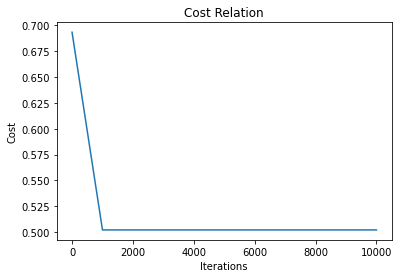

In [119]:
model_wtSigmoid.train(train_x,train_y)

##### 7.2 Predicting from the trained model

In [120]:
test_predictionSigmoid = model_wtSigmoid.predict(test_x)

##### 7.3 Metrics

In [121]:
Metrics(test_y,test_predictionSigmoid)

Accuracy: 82.47%
Precision:0.77
Recall Score:0.73
F1 Score:0.75
